# Exercise sheet 11 - Parallelisation

# Exercise 1 - Rigged dice

Create a rigged dice function that 25% of the time returns the number 6. The rest of the time it returns the integers 1,2,3,4,5 uniformly.
Test your function, by calling it **one billion times** (10^9) and checking that 6 is returned in the range of 249-251 million (inclusive) times. You do not need to check that numbers 1 to 5 are returned uniformly or randomly, but you need to check that your function returns integers in the range 1-6 (inclusive). **Time** how long it takes to run the script.

Now attempt to **parallelise the task with a method of your own choosing** and time how long it takes once more. How does this compare to the previous *un-optimised* run?


In [ ]:
import random
import time
import multiprocessing as mp

def rigged_dice():
    if random.random() < 0.25:
        return 6
    return random.randint(1, 5)

def worker(n_rolls):
    count_6 = 0
    for _ in range(n_rolls):
        if rigged_dice() == 6:
            count_6 += 1
    return count_6

if __name__ == "__main__":
    N = 10**7
    PROCESSES = mp.cpu_count()

    print(f"Using {PROCESSES} CPU cores | Total rolls: {N:,}")

    #Sequential
    start = time.time()
    count_seq = worker(N) # Reuse worker for sequential
    time_seq = time.time() - start
    print(f"Sequential: {count_seq:,} sixes in {time_seq:.2f}s")

    # Parallel
    # Distribute remainder rolls to avoid losing data (e.g. 10 rolls / 3 processes)
    remainder = N % PROCESSES
    tasks = [N // PROCESSES + 1] * remainder + [N // PROCESSES] * (PROCESSES - remainder)

    start = time.time()
    with mp.Pool(PROCESSES) as pool:
        count_par = sum(pool.map(worker, tasks))
    time_par = time.time() - start
    
    print(f"Parallel:   {count_par:,} sixes in {time_par:.2f}s")
    print(f"Speedup:    {time_seq / time_par:.2f}x")


Using 4 CPU cores | Total rolls: 10,000,000
Sequential: 2,500,885 sixes in 4.05s
Parallel:   2,500,907 sixes in 1.97s
Speedup:    2.05x


# Exercise 2 - Calculate $\pi$

Using the **DSMC method**, calculate the value of **$\pi$**.


**Approach:**
In order to do this, create a 2-dimensional domain (defined by the coordinates $x_{min}, x_{max}, y_{min}, y_{max}$) and launch a number P of particles at random locations within. Check which particles lie inside a circle with radius $$ \frac{x_{max}-x_{min}}{2}, $$ where $x_{min}, x_{max}$ are the x-limits of your 2D domain. 

Get your value for $\pi$ by using the following formula:
$\pi = \frac{4 \cdot n_{inside}}{P},$ where $n_{inside}$ is the number of particles inside the circle and $P$ is the total number of particles.

Play around with the number of particles. 

**a)** Try to improve this task by making use of threading (you can use either the **_thread** or **threading** module). What are your findings, is the script running faster? 

**b)** Now try to improve the running time of the code by employing the **multiprocessing** module. Are there any differences as compared to threading?

In [ ]:
import random
import time
import threading
import multiprocessing as mp

# Shared Worker
def count_inside(n_points):
    inside = 0
    for _ in range(n_points):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x*x + y*y <= 1:
            inside += 1
    return inside


# Threading version 
def threaded_pi(n_points, n_threads):
    inside_total = 0
    lock = threading.Lock()
    points_per_thread = n_points // n_threads

    def worker(n):
        nonlocal inside_total
        with lock:
            inside_total += count_inside(n)

    threads = []
    for _ in range(n_threads):
        t = threading.Thread(target=worker, args=(points_per_thread,))
        threads.append(t)
        t.start()

    for t in threads:
        t.join()

    return 4 * inside_total / n_points


if __name__ == "__main__":
    N = 10_000_000
    WORKERS = mp.cpu_count()
    print(f"Using {WORKERS} CPU cores\n")

    # 1. Sequential
    start = time.time()
    pi_seq = 4 * count_inside(N) / N
    print(f"Sequential π ≈ {pi_seq:.6f}, time = {time.time() - start:.2f}s")

    # 2. Threading
    start = time.time()
    pi_thread = threaded_pi(N, WORKERS)
    print(f"Threaded π   ≈ {pi_thread:.6f}, time = {time.time() - start:.2f}s")

    # 3. Multiprocessing
    start = time.time()
    points_per_process = N // WORKERS
    with mp.Pool(processes=WORKERS) as pool:
        results = pool.map(count_inside, [points_per_process] * WORKERS)
    
    pi_mp = 4 * sum(results) / N
    print(f"Multiproc π  ≈ {pi_mp:.6f}, time = {time.time() - start:.2f}s")

Using 4 CPU cores

Sequential π ≈ 3.141867, time = 4.24s
Threaded π   ≈ 3.141060, time = 4.23s
Multiproc π  ≈ 3.141737, time = 2.17s


# Exercise 3 - Mandelbrot fractals

Read about the Mandelbrot set: https://en.wikipedia.org/wiki/Mandelbrot_set. 
This set is defined by repeatedly applying this recurrence:

$z_{n+1} = z_{n}^2 + c$,

which starts with $z_{0} = 0$ for a given complex number $c$ (each pixel corresponds to one $c$). The idea is to check if a particle "escapes" at a certain iteration. At each iteration, one checks if the sequence $z_0, z_1, ... z_n$ growing or stays bound. The growing condition: $|z_n| > 2$. If the condition ```if (z.real*z.real + z.imag*z.imag) > 4``` is fulfilled at any step, we mark the particle as "escaped". If the sequence stays bound forever (never uncontrollably grows for a given number of iterations, for instance, 300), then it is inside the the Mandelbrot set.

**(A)** Create a script which visualizes the Mandelbrot set. The X-axis is the real part of the complex number, the Y-axis is the imaginary part. You can use the colorscheme of your choice. Mark the particles which never escape as one color, and color the escaped particles based on how fast they escaped (that is, use the iteration at which they escaped for your colorbar). You should define the width and height of your image (for instance, 1000 and 700, but you can change it if you like), and 

**(B)** Parallelize your Mandelbrot function using the *multiprocessing* module. Experiment with different sizes of datachunks you give separate processors (you can split the data by column chunks or row chunks and process them separately in separate processes).



Calculating 800x800 Mandelbrot set...
Sequential time: 4.46s
Parallel time:   2.13s
Speedup:         2.09x


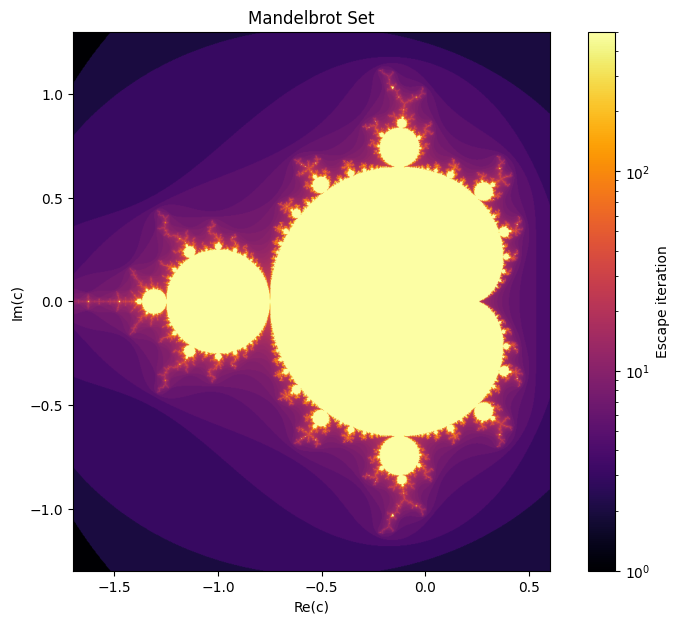

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import time
from matplotlib.colors import LogNorm

# Pre-compute coordinates for the grid
def get_grid(width, height, x_min, x_max, y_min, y_max):
    x = np.linspace(x_min, x_max, width)
    y = np.linspace(y_min, y_max, height)
    return x, y

# Worker function (calculates one row)
def mandelbrot_row(y_index, x_vals, y_val, max_iter):
    width = len(x_vals)
    row = np.zeros(width, dtype=np.int32)
    
    # Create complex numbers for the entire row at once
    c = x_vals + 1j * y_val

    z = np.zeros(width, dtype=np.complex128)

    for n in range(max_iter):
        # Check which points are still bounded (haven't escaped)
        mask = np.abs(z) <= 2
        
        # If all points have escaped, we can stop early
        if not np.any(mask):
            break
        
        # Update z for the points that are still bounded
        z[mask] = z[mask]**2 + c[mask]
        
        # Check for points that escaped exactly in this iteration
        escaped = mask & (np.abs(z) > 2)
        row[escaped] = n + 1
        
    # Points that never escaped remain 0, set them to max_iter
    row[row == 0] = max_iter 
    return y_index, row


# Sequential
def mandelbrot_sequential(width, height, max_iter):
    x_vals, y_vals = get_grid(width, height, -1.7, 0.6, -1.3, 1.3)
    image = np.zeros((height, width), dtype=np.int32)

    for y, y_val in enumerate(y_vals):
        _, image[y] = mandelbrot_row(y, x_vals, y_val, max_iter)

    return image


# Parallel
def mandelbrot_parallel(width, height, max_iter):
    x_vals, y_vals = get_grid(width, height, -1.7, 0.6, -1.3, 1.3)
    image = np.zeros((height, width), dtype=np.int32)

    # Prepare arguments for starmap
    args = [(y, x_vals, y_val, max_iter) for y, y_val in enumerate(y_vals)]

    with mp.Pool(mp.cpu_count()) as pool:
        for y, row in pool.starmap(mandelbrot_row, args):
            image[y] = row

    return image


if __name__ == "__main__":
    WIDTH = 800
    HEIGHT = 800
    MAX_ITER = 500

    print(f"Calculating {WIDTH}x{HEIGHT} Mandelbrot set...")
    
    # Sequential
    start = time.time()
    img_seq = mandelbrot_sequential(WIDTH, HEIGHT, MAX_ITER)
    t_seq = time.time() - start
    print(f"Sequential time: {t_seq:.2f}s")

    # Parallel
    start = time.time()
    img_par = mandelbrot_parallel(WIDTH, HEIGHT, MAX_ITER)
    t_par = time.time() - start
    print(f"Parallel time:   {t_par:.2f}s")
    print(f"Speedup:         {t_seq / t_par:.2f}x")

    # Plot
    plt.figure(figsize=(10, 7))
    plt.imshow(img_par, cmap="inferno", extent=(-1.7, 0.6, -1.3, 1.3), norm=LogNorm(vmin=1, vmax=MAX_ITER))
    plt.colorbar(label="Escape iteration")
    plt.xlabel("Re(c)")
    plt.ylabel("Im(c)")
    plt.title("Mandelbrot Set")
    plt.show()